## Load Librarires

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Load dataset


In [35]:
df = pd.read_csv("Electric_Vehicle_Dataset.csv")
df.shape, df.head()


((1320, 20),
   User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
 0  User_1        BMW i3              108.463007         Station_391   
 1  User_2  Hyundai Kona              100.000000         Station_428   
 2  User_3    Chevy Bolt               75.000000         Station_181   
 3  User_4  Hyundai Kona               50.000000         Station_327   
 4  User_5  Hyundai Kona               50.000000         Station_108   
 
   Charging Station Location Charging Start Time Charging End Time  \
 0                   Houston         1/1/24 0:00       1/1/24 0:39   
 1             San Francisco         1/1/24 1:00       1/1/24 3:01   
 2             San Francisco         1/1/24 2:00       1/1/24 4:48   
 3                   Houston         1/1/24 3:00       1/1/24 6:42   
 4               Los Angeles         1/1/24 4:00       1/1/24 5:46   
 
    Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
 0              60.712346                   0.591363   

## Correlation Plot

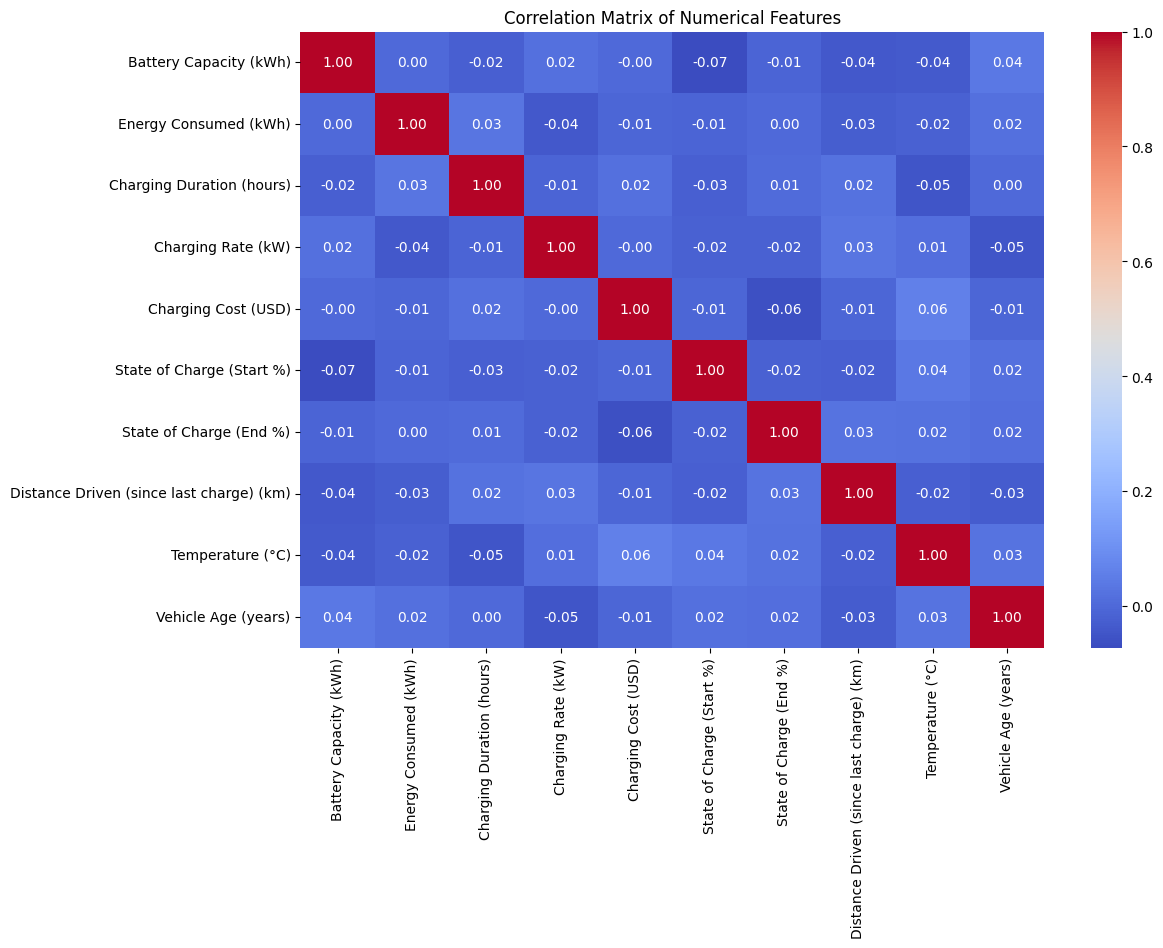

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


## Data Cleaning and Pipeline Formation

In [37]:
df = df.dropna(subset=['User Type'])

X = df.drop(columns=[
    'User ID', 'Charging Station ID', 'Charging Station Location',
    'Charging Start Time', 'Charging End Time', 'User Type'
])
y = df['User Type']

num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


## Train-Test Split
 Train Size - 80%
 Test Size - 10%
 Validation Size - 10%

In [38]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (792, 14)
Validation size: (264, 14)
Test size: (264, 14)


## Model Building

In [39]:
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"classifier__C": [0.01, 0.1, 1, 10]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(),
        {"classifier__max_depth": [5, 10, 15]}
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {"classifier__n_estimators": [50, 100], "classifier__max_depth": [10, 20]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(n_iter_no_change=5, validation_fraction=0.1),
        {}  # no grid search
    ),
    "SVM": (
        SVC(),
        {"classifier__C": [0.1, 1, 10], "classifier__gamma": ['scale', 'auto']}
    ),
    "Neural Network": (
        MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300),
        {}  # no grid search
    )
}


## Grid Search and Model Comparison

In [ ]:
results = {}
best_estimators = {}

for name, (model, params) in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    if params:
        grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='f1_weighted', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_estimators[name] = best_model
        y_pred = best_model.predict(X_test)
        results[name] = {
            "best_params": grid.best_params_,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred, average="weighted"),
            "report": classification_report(y_test, y_pred, output_dict=True)
        }
    else:
        pipe.fit(X_train, y_train)
        best_estimators[name] = pipe
        y_pred = pipe.predict(X_test)
        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred, average="weighted"),
            "report": classification_report(y_test, y_pred, output_dict=True)
        }

summary_df = pd.DataFrame([
    {
        "Model": model,
        "Accuracy": f"{metrics['accuracy']:.3f}",
        "F1 Score": f"{metrics['f1_score']:.3f}",
        "Best Params": metrics.get("best_params", "N/A")
    }
    for model, metrics in results.items()
])
summary_df


C:\Users\nikhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,F1 Score,Best Params
0,Logistic Regression,0.341,0.337,{'classifier__C': 1}
1,Decision Tree,0.330,0.329,{'classifier__max_depth': 5}
2,Random Forest,0.322,0.312,"{'classifier__max_depth': 10, 'classifier__n_e..."
3,Gradient Boosting,0.364,0.303,N/A
4,SVM,0.295,0.294,"{'classifier__C': 10, 'classifier__gamma': 'au..."
5,Neural Network,0.307,0.305,N/A


## Decision Tree

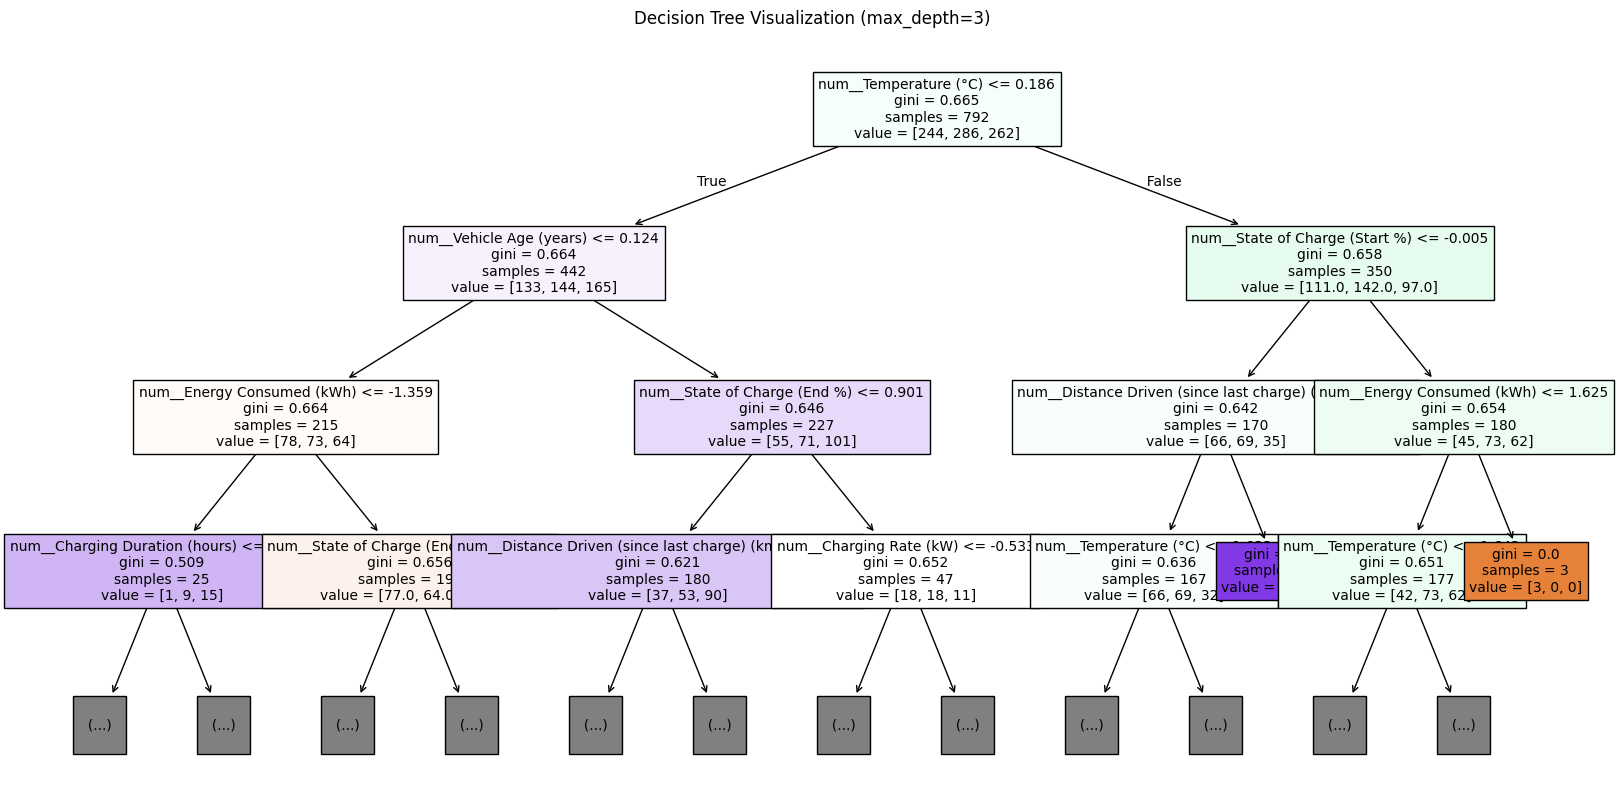

In [41]:
tree_model = best_estimators["Decision Tree"].named_steps["classifier"]
plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, max_depth=3, fontsize=10, feature_names=preprocessor.get_feature_names_out())
plt.title("Decision Tree Visualization (max_depth=3)")
plt.show()


## Feature Importance in Random Forest

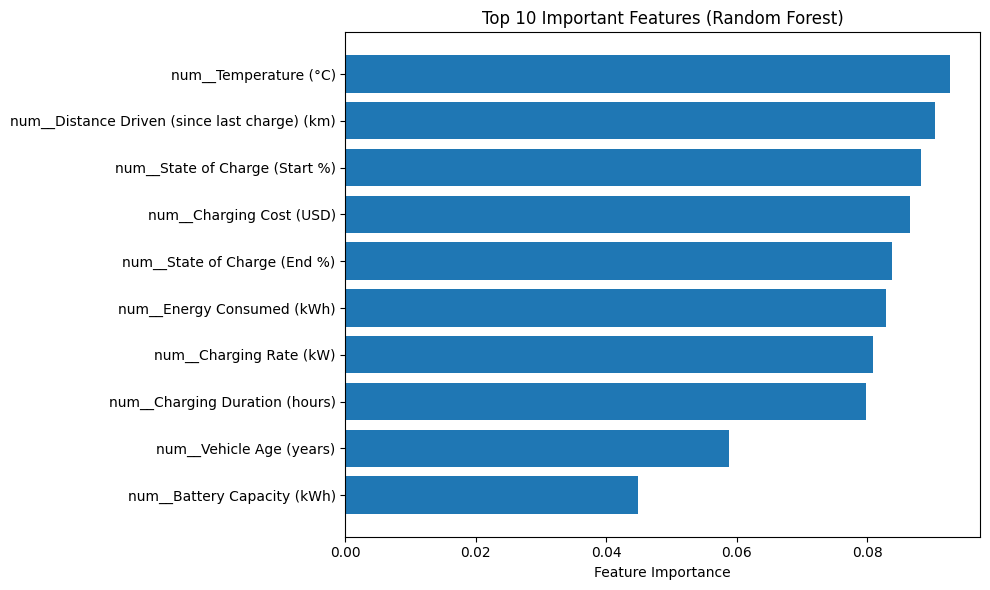

In [42]:
rf_model = best_estimators["Random Forest"].named_steps["classifier"]
rf_features = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_

top_idx = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[top_idx], align='center')
plt.yticks(range(10), rf_features[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


## Confusion Matrix for Support Vector Machines

<Figure size 800x600 with 0 Axes>

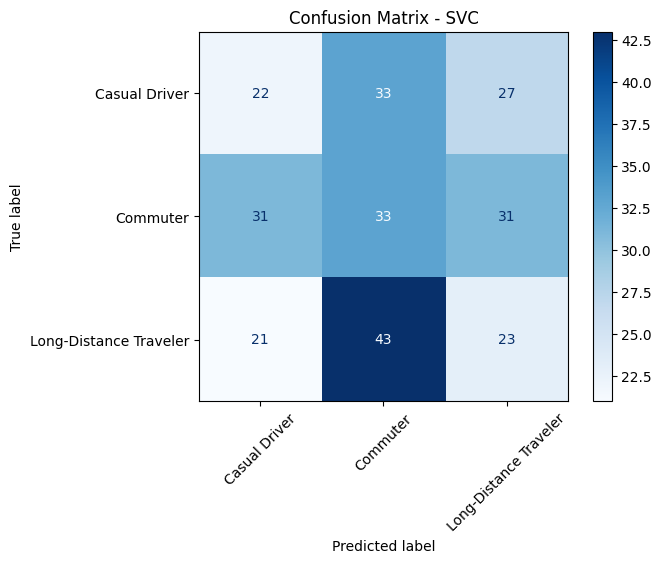

In [ ]:
svc_model = best_estimators["SVM"]
y_pred_svc = svc_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_svc, labels=svc_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - SVC")
plt.show()
